# Exploring  ALIBI (Algorithms for explaining machine learning models)
## CHAPTER 09 - *Other popular XAI frameworks*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

Previously, in [chapter 2](https://github.com/PacktPublishing/Applied-Machine-Learning-Explainability-Techniques/tree/main/Chapter02), we have covered the [Counterfactual Explanation Tutorial](https://github.com/PacktPublishing/Applied-Machine-Learning-Explainability-Techniques/blob/main/Chapter02/Counterfactual_structured_data.ipynb), where you have received some exposure on the [ALIBI framework](https://github.com/SeldonIO/alibiE). In this tutorial, you will get a deeper exposure to the ALIBI framework on a different problem. We will use the same Occupancy Detection Dataset used in the [DiCE tutorial](https://github.com/PacktPublishing/Applied-Machine-Learning-Explainability-Techniques/blob/main/Chapter09/DiCE_example.ipynb). So, the initial part of the tutorial might look same, but the model explainabilty part will be different as we will be using various components from the ALIBI framework.

### Installing the modules

Install the following libraries in Google Colab or your local environment, if not already installed.

In [ ]:
!pip install --upgrade pandas numpy matplotlib seaborn scikit-learn tensorflow alibi

### Loading the modules

In [114]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

import alibi
from alibi.explainers import AnchorTabular, CEM, CounterfactualProto


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from IPython import display
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs

np.random.seed(123)
tf.random.set_seed(123)

### About the data

**Occupancy Detection dataset | [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+#)**

Original Source: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+#

Discovered from : https://code.datasciencedojo.com/datasciencedojo/datasets/tree/master/Occupancy%20Detection

- This data set has 20560 rows and 7 attributes which are divided into 3 data sets for training, validation  and testing.

- The data set provides experimental data used for binary classification (room occupancy of an office room) from Temperature, Humidity, Light and CO2. 

- Ground-truth occupancy was obtained from time stamped pictures that were taken every minute.This dataset is recommended for classification based problems.

This data set has been sourced from the Machine Learning Repository of University of California, Irvine [Occupancy Detection Data Set (UC Irvine)](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+#). The UCI page mentions the following publication [Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. Luis M. Candanedo, VÃ©ronique Feldheim. Energy and Buildings. Volume 112, 15 January 2016, Pages 28-39](https://www.researchgate.net/profile/Luis_Candanedo_Ibarra/publication/285627413_Accurate_occupancy_detection_of_an_office_room_from_light_temperature_humidity_and_CO2_measurements_using_statistical_learning_models/links/5b1d843ea6fdcca67b690c28/Accurate-occupancy-detection-of-an-office-room-from-light-temperature-humidity-and-CO2-measurements-using-statistical-learning-models.pdf?origin=publication_detail) as the original source of the data set.

And thanks to Data Science Dojo - https://code.datasciencedojo.com/ - for curating this dataset, thus making it more discoverable!

### Loading the data

In [16]:
# We will read the training data, validation and test data
df_train = pd.read_csv('datasets/Occupancy_Detection_Data/train.csv')
df_valid = pd.read_csv('datasets/Occupancy_Detection_Data/valid.csv')
df_test = pd.read_csv('datasets/Occupancy_Detection_Data/test.csv')

In [17]:
df_train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2/4/2015 17:51,23.18,27.2720,426.0,721.25,0.004793,1
1,2/4/2015 17:51,23.15,27.2675,429.5,714.00,0.004783,1
2,2/4/2015 17:53,23.15,27.2450,426.0,713.50,0.004779,1
3,2/4/2015 17:54,23.15,27.2000,426.0,708.25,0.004772,1
4,2/4/2015 17:55,23.10,27.2000,426.0,704.50,0.004757,1


In [18]:
# Reading the dataset description
with open('datasets/Occupancy_Detection_Data/description.txt') as f:
    contents = f.read()
    print(contents)

--------------------------------------------------------------------------------------------------------------------------
Occupancy Detection Dataset
--------------------------------------------------------------------------------------------------------------------------
Original Source: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+#
Discovered from : https://code.datasciencedojo.com/datasciencedojo/datasets/tree/master/Occupancy%20Detection

---

- This data set has 20560 rows and 7 attributes which are divided into 3 data sets for training, validation  and testing.

- The data set provides experimental data used for binary classification (room occupancy of an office room) from Temperature, Humidity, Light and CO2. 

- Ground-truth occupancy was obtained from time stamped pictures that were taken every minute.This dataset is recommended for classification based problems.

---

### Data Dictionary 
As mentioned in : https://code.datasciencedojo.com/datasciencedojo/data

In [19]:
# Check dataset dimensions
print(df_train.shape)

(8143, 7)


In [20]:
df_train.columns

Index(['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
       'Occupancy'],
      dtype='object')

0    6414
1    1729
Name: Occupancy, dtype: int64

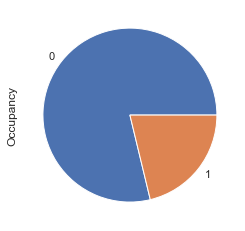

In [21]:
df_train['Occupancy'].value_counts().plot(kind='pie')
df_train['Occupancy'].value_counts()

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 445.4+ KB


As we can see, the dataset contains close to 8143 records and 6 features. The `date` feature doesn't seem to be relevant to detect room occupancy and we want to perform this detection solely based on the sensor values. So, we will drop this feature. We may need to perform further data normalization or transformation, but luckily there is no missing values, and thus no need for data imputation or additional steps to handle missing value. In the next step, we will perform some preliminary data processing and exploration, required for building the model. But I do recommend all of you to perform a detailed EDA, data processing, feature engineering in order to get a well trained model. 

### Data Pre-processing

In [23]:
# Let's create a generic scikit-learn pipeline for training, validation and test data

In [24]:
# Drop un-necessary features
features_to_drop = ['date']
target_variable = 'Occupancy'
y_train = df_train[target_variable]
y_valid = df_valid[target_variable]
y_test = df_test[target_variable]

numeric = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'] # All features in this dataset is numerical
categorical = [] # No categorical feature in this dataset

In [25]:
def drop_not_wanted_features(df):
    '''
    Function to drop unwanted features
    '''    
    df.drop(columns='date', inplace=True)
    df.drop(columns='Occupancy', inplace=True)
    
    return df

In [26]:
df_train = drop_not_wanted_features(df_train)
df_valid = drop_not_wanted_features(df_valid)
df_test = drop_not_wanted_features(df_test)

In [27]:
# Let's create preprocessing pipelines for both numeric and categorical data.

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [28]:
column_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical)])

### Training the model

In [29]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
# You can further add other custom pipelines
clf = Pipeline(steps=[('preprocessor', column_transformer),
                      ('classifier', RandomForestClassifier(n_estimators=300,
                                                            random_state=123))])

In [30]:
model = clf.fit(df_train, y_train)

In [32]:
# Accuracy score on validation dataset
model.score(df_valid, y_valid)

0.9770303527481542

In [33]:
# Accuracy score on test dataset
accuracy_score(model.predict(df_test), y_test)

0.951594746716698

In [34]:
# ROC_AUC score on test dataset
roc_auc_score(model.predict(df_test), y_test)

0.9501350997513132

## Model Explainability using ALIBI

[ALIBI](https://github.com/SeldonIO/alibi/tree/master/doc/source/examples) supports a wide range of operation with various types of dataset (tabular, images, text etc.). Previously in [Chapter 2](https://github.com/PacktPublishing/Applied-Machine-Learning-Explainability-Techniques/blob/main/Chapter02/Counterfactual_structured_data.ipynb), we have explored only the counterfactual explanations, now we will explore the other explainability methods available in ALIBI as well. Let's begin!

### Anchor Explainations

TO-DO - Define what is anchor explaination

In [35]:
def reverse_transform(numpy_array, all_features):
    return pd.DataFrame(numpy_array, columns = all_features)

In [36]:
predict_fn = lambda x: model.predict_proba(reverse_transform(x, list(df_train.columns)))

In [37]:
explainer = AnchorTabular(predict_fn, 
                          feature_names=list(df_train.columns), 
                          seed=123)

In [38]:
explainer.fit(df_train.values, disc_perc=[25, 50, 75])

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'disc_perc': [25, 50, 75], 'seed': 123},
  'version': '0.6.2'}
)

#### Setting an anchor

For model explainability using anchors, first we need an anchor for the prediction of the first observation in the test set. An anchor is a sufficient condition - that is, when the anchor holds, the prediction should be the same as the prediction for this instance.

In [55]:
idx = 5
class_names = ['not_occupied', 'occupied']
print('Prediction: ', class_names[explainer.predictor(df_test.values[idx].reshape(1, -1))[0]])

Prediction:  not_occupied


Now, we need to set a precision threshold, which will be like the confidence interval from the anchor. We will set the precision threshold to 0.8. This means that predictions on observations where the anchor holds will be the same as the prediction on the explained instance at least 80% of the time.

In [56]:
explanation = explainer.explain(df_test.values[idx], threshold=0.8)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Anchor: CO2 > 439.00
Precision: 0.83
Coverage: 0.75


Accordingly, we can increase or decrease the precision to best suit our needs.

Next, let us get try to get an anchor for a prediction for the `occupied` class.

In [57]:
idx = 100
class_names = ['not_occupied', 'occupied']
print('Prediction: ', class_names[explainer.predictor(df_test.values[idx].reshape(1, -1))[0]])

explanation = explainer.explain(df_test.values[idx], threshold=0.8)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  occupied
Anchor: Light > 256.38 AND CO2 > 638.83
Precision: 0.98
Coverage: 0.20


As we can see from the result, the anchor from the occupied class makes more sense, as it suggests that when the light is on with a certain intensity and when the CO2 level is high, this indicate that the room is occupied.

Next let us cover another different method.

### Contrastive Explanations Method (CEM)

The Contrastive Explanation Method (CEM) can produce explanations for black-box models with respect to pertinent positives (PP) and pertinent negatives (PN). For PP, it finds what should be minimally and sufficiently present (e.g. important pixels in an image) to justify its classification. PN on the other hand identify what should be minimally and necessarily absent from the explained instance in order to maintain the original prediction. Check out the [original research lierature](https://arxiv.org/pdf/1802.07623.pdf) to get a better understanding of the theoretical concept.

#### CEM with pertinent negative

In [76]:
idx = 0
X = df_test[idx:idx+1]

print(f'Prediction for the data instance selected : {class_names[model.predict(X)[0]]}')
print(f'Prediction probabilities : {model.predict_proba(X)[0]}')

Prediction for the data instance selected : not_occupied
Prediction probabilities : [0.52333333 0.47666667]


In [109]:
# Define the CEM parameters
# Using the same parameters as from - https://github.com/SeldonIO/alibi/blob/master/doc/source/examples/cem_iris.ipynb

mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = X.shape  # data instance shape
kappa = .2   # minimum difference needed between the prediction probability for the perturbed instance on the
             # class predicted by the original instance and the max probability on the other classes 
             # in order for the first loss term to be minimized
beta = .1   # weight of the L1 loss term
c_init = 10.  # initial weight c of the loss term encouraging to predict a different class (PN) or 
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (df_train.values.min(axis=0).reshape(shape)-.1,  # feature range for the perturbed instance
                 df_train.values.min(axis=0).reshape(shape)+.1)  # can be either a float or array of shape (1xfeatures)
clip = (-1000.,1000.)  # gradient clipping
lr_init = 1e-2  # initial learning rate

In [110]:
# initialize CEM explainer and explain instance
cem = CEM(predict_fn, mode, shape, 
          kappa=kappa, beta=beta, feature_range=feature_range, 
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps, 
          learning_rate_init=lr_init, clip=clip)

cem.fit(df_train.values, no_info_type='median') # we need to define what feature values contain the least
                                                # info wrt predictions
                                                # here we will naively assume that the feature-wise median
                                                # contains no info; domain knowledge helps!
explanation = cem.explain(X, verbose=False)

No PN found!


In [111]:
print(f'Original instance: {explanation.X}')
print(f'Predicted class: {class_names[explanation.X_pred]}')

Original instance:    Temperature  Humidity  Light    CO2  HumidityRatio
0         23.7    26.272  585.2  749.2       0.004764
Predicted class: not_occupied


In [112]:
print(f'Pertinent negative: {explanation.PN}')

Pertinent negative: None


For this example, no pertinent negative is found. This indicates that all the features are important and considered by the model for the prediction. Usually for higher dimensional data, you might find PN to be very helpful. Now, let's find out PP for this dataset

#### CEM with pertinent positives

In [91]:
mode = 'PP'

# initialize CEM explainer and explain instance
cem = CEM(predict_fn, mode, shape, kappa=kappa, 
          beta=beta, feature_range=feature_range, 
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps, 
          learning_rate_init=lr_init, clip=clip)
cem.fit(df_train.values, no_info_type='median')
explanation = cem.explain(X, verbose=False)

In [99]:
print(f'Pertinent positive: ')
display.display(explanation.PP)
print(f'Predicted class: {class_names[explanation.PP_pred]}')

Pertinent positive: 


,Temperature,Humidity,Light,CO2,HumidityRatio
0,-7.629395e-07,6.408691e-07,-0.000012,-0.000012,6.468344e-11


Predicted class: not_occupied


We can further analyze the difference between PP and PN, but since we do not have any PN, we will not be able to compare with the generated PP values. Next, let us use Alibi for getting the counterfactuals.

### Counterfactual Explanations

In [117]:
# Define CFE parameters for Alibi - from: https://github.com/SeldonIO/alibi/blob/master/doc/source/examples/cfproto_cat_adult_ohe.ipynb
shape = X.shape
beta = .01
c_init = 1.
c_steps = 5
max_iterations = 500
rng = (-1., 1.)  # scale features between -1 and 1

feature_range = ((np.ones(shape) * rng[0]).astype(np.float32), 
                 (np.ones(shape) * rng[1]).astype(np.float32))

In [123]:
cfe = CounterfactualProto(predict_fn,
                          shape,
                          use_kdtree=True, 
                          theta=10., 
                          max_iterations=1000,
                          c_init=1., 
                          c_steps=10
                         )

In [124]:
cfe.fit(df_train.values, d_type='abdm', disc_perc=[25, 50, 75]);
'''
Supported values for d_type is:
- 'abdm' infers context from the other variables 
- 'mvdm' uses the model predictions.
- 'abdm-mvdm' is a weighted combination of the two metrics.
'''

No encoder specified. Using k-d trees to represent class prototypes.


"\nSupported values for d_type is:\n- 'abdm' infers context from the other variables \n- 'mvdm' uses the model predictions.\n- 'abdm-mvdm' is a weighted combination of the two metrics.\n"

In [125]:
# Let's generate counterfactuals for the test instance
explanation = cfe.explain(X)

In [128]:
print(f'Original prediction: {explanation.orig_class}')
print('Counterfactual prediction: {}'.format(explanation.cf['class']))

Original prediction: 0
Counterfactual prediction: 1


In [130]:
# Now let's see the counterfactual example
counterfactual = explanation.cf['X'].astype(int)
change = counterfactual - X
df_cfe = pd.DataFrame(counterfactual, columns = numeric)
df_cfe

,Temperature,Humidity,Light,CO2,HumidityRatio
0,23,25,581,751,0


In [136]:
# Let's see the difference between counterfactual and original instance
for i, feature_names in enumerate(numeric):
    if change[feature_names][0] != 0:
        print(f"The feature {feature_names} has to change by {round(change[feature_names][0],3)}")

The feature Temperature has to change by -0.7
The feature Humidity has to change by -1.272
The feature Light has to change by -4.2
The feature CO2 has to change by 1.8
The feature HumidityRatio has to change by -0.005


Thus, we can get the counterfactual examples. Although, I think further hyper-parameter tuning is required for generating the counterfactuals, as the degree of change for the feature values seems to b

### Accumulated Local Effects

## Final Thoughts

## Reference

1. Dataset link - Occupancy Detection dataset | [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+#)
2. ALIBI Github project - https://github.com/SeldonIO/alibi
6. ALIBI Documentation - https://docs.seldon.io/projects/alibi/en/latest/
7. Other notebook examples: https://github.com/SeldonIO/alibi/tree/master/doc/source/examples
8. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073
9. Want to connect with the author of this chapter? You can reach out by any means mentioned here: https://aditya-bhattacharya.net/contact-me/